In [24]:
# ---- Imports ----
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import plot_importance
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import matplotlib.pyplot as plt

In [51]:
# ---- Import dataset ----
df = pd.read_csv('./data/train.csv')

# ---- Data preprocessing ----
# -- we will only train with numerical variables, so any object/categories must be converted here --

# is superhost is just a binary variable
df['host_is_superhost_encoded'] = (
    df['host_is_superhost']
    .infer_objects(copy=False)
    .astype(bool)
    .astype(int)
)

# host response time is oridinal
response_time_mapping = {
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1
}
df['host_response_time_encoded'] = df['host_response_time'].map(response_time_mapping)

# assume that room type is ordinal. full houses more expensive than shared rooms
room_type_mapping = {
    'Entire home/apt': 3,
    'Private room': 2,
    'Hotel room': 1,
    'Shared room': 0
}
df['room_type_encoded'] = df['room_type'].map(room_type_mapping)

# host since can be treated as continuous variable
df['host_since'] = pd.to_datetime(df['host_since'])
df['host_years'] = 2024 - df['host_since'].dt.year

# handle boroughs. don't worry about uncleansed neighborhood locations yet
df['neighbourhood_group_cleansed'] = df['neighbourhood_group_cleansed'].fillna(value='Unknown', method=None)

df = pd.get_dummies(df, columns=['neighbourhood_group_cleansed'], drop_first=False)

# add bool indicating whether a listing has no reviews
df['has_review'] = df['reviews'].apply(lambda x: 0 if pd.isna(x) or len(x.strip()) == 0 else 1)

KeyError: 'id'

In [3]:
# -- NLP processing --
# # load pre-trained model
# model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

# # sentiment analysis pipeline
# sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0)

# # analyze and update
# df['sentiment'] = df['reviews'].apply(lambda x: sentiment_analyzer(x)[0])

In [4]:
excluded_features = [
    'price', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location', 
    'review_scores_value', 'reviews_per_month', 
    'host_response_rate', 'host_response_time_encoded',
    'host_acceptance_rate']

# print features to be used
evaluated_features = df.select_dtypes(include=['float64', 'int64', 'bool']).columns.tolist()
evaluated_features = [col for col in evaluated_features if col not in excluded_features]

# only numerical features
numerical_features = df[evaluated_features].select_dtypes(include=['float64', 'int64']).columns.tolist()

In [5]:
# check for missing values in the used columns
print(df[evaluated_features].isnull().sum().sort_values(ascending=False)[:5])

beds                    84
bedrooms                34
bathrooms                3
latitude                 0
host_has_profile_pic     0
dtype: int64


In [6]:
# ---- Impute missing data ----
# for now, just remove whole data points with missing data
columns_to_check = ['beds', 'bedrooms', 'bathrooms']

# Number of rows before dropping
print(f"Rows before dropping: {df.shape[0]}")

# Drop rows with missing values in specified columns
df_cleaned = df.dropna(subset=columns_to_check)

# Number of rows after dropping
print(f"Rows after dropping: {df_cleaned.shape[0]}")


Rows before dropping: 15696
Rows after dropping: 15576


In [33]:
%timeit

# extract data
X = df_cleaned[evaluated_features]
y = df_cleaned['price']

# split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# create and train model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# predict on validation set
y_pred = model.predict(X_val)

# Evaluate
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

/home/users/mas296/micromamba/envs/cs671/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:44:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1730232887822/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5933889602053916
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       529
           1       0.52      0.56      0.54       542
           2       0.46      0.44      0.45       495
           3       0.46      0.48      0.47       550
           4       0.52      0.50      0.51       481
           5       0.81      0.75      0.78       519

    accuracy                           0.59      3116
   macro avg       0.60      0.59      0.59      3116
weighted avg       0.60      0.59      0.59      3116



In [34]:
# extract data
X = df_cleaned[evaluated_features]
y = df_cleaned['price']

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for CV optimization
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBClassifier
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Perform grid search on training data
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_model = grid_search.best_estimator_

# Predict on validation set using the best model
y_pred = best_model.predict(X_val)

# Evaluate
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Accuracy: 0.6026957637997432
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81       529
           1       0.52      0.55      0.54       542
           2       0.47      0.49      0.48       495
           3       0.48      0.49      0.48       550
           4       0.54      0.51      0.52       481
           5       0.81      0.77      0.79       519

    accuracy                           0.60      3116
   macro avg       0.61      0.60      0.60      3116
weighted avg       0.61      0.60      0.60      3116



<Figure size 1000x800 with 0 Axes>

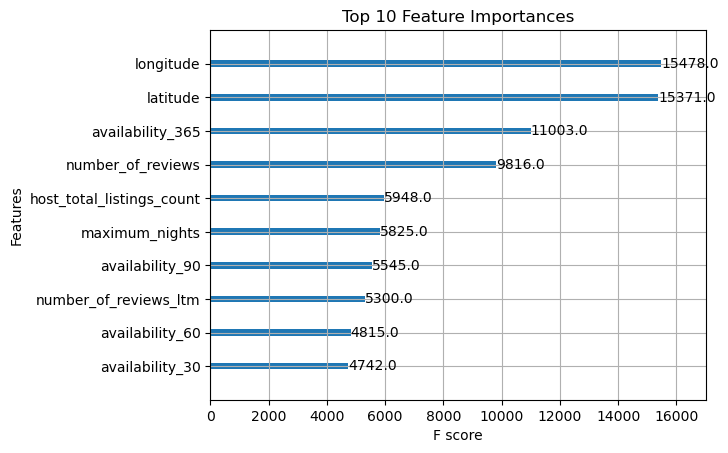

<Figure size 1000x800 with 0 Axes>

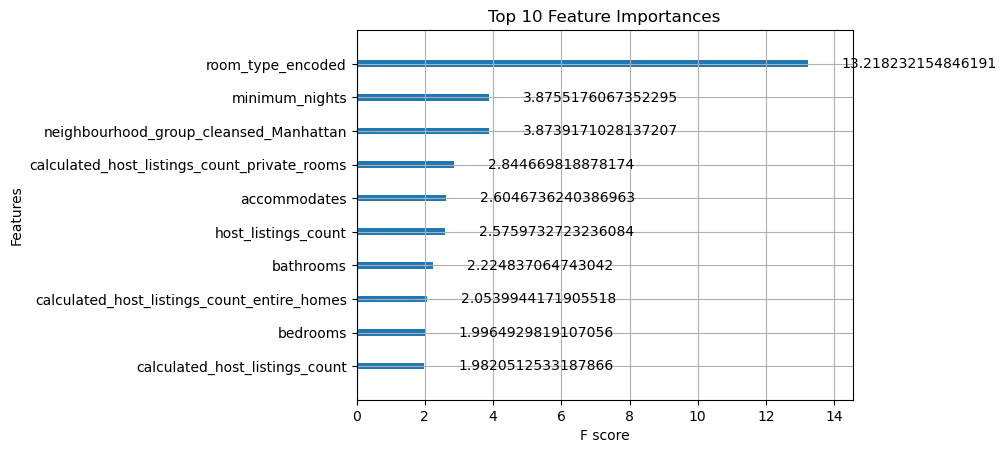

In [36]:
plt.figure(figsize=(10, 8))
plot_importance(best_model, max_num_features=10, importance_type='weight')
plt.title('Top 10 Feature Importances')
plt.show()

plt.figure(figsize=(10, 8))
plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title('Top 10 Feature Importances')
plt.show()

In [31]:
# test prediction and export
y_pred = best_model.predict(X_val)

ValueError: Unsupported dtype object

In [63]:
# ---- Import dataset ----
df = pd.read_csv('./data/test.csv')

# ---- Data preprocessing ----
# -- we will only train with numerical variables, so any object/categories must be converted here --

# is superhost is just a binary variable
df['host_is_superhost_encoded'] = (
    df['host_is_superhost']
    .infer_objects(copy=False)
    .astype(bool)
    .astype(int)
)

# host response time is oridinal
response_time_mapping = {
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1
}
df['host_response_time_encoded'] = df['host_response_time'].map(response_time_mapping)

# assume that room type is ordinal. full houses more expensive than shared rooms
room_type_mapping = {
    'Entire home/apt': 3,
    'Private room': 2,
    'Hotel room': 1,
    'Shared room': 0
}
df['room_type_encoded'] = df['room_type'].map(room_type_mapping)

# host since can be treated as continuous variable
df['host_since'] = pd.to_datetime(df['host_since'])
df['host_years'] = 2024 - df['host_since'].dt.year

# handle boroughs. don't worry about uncleansed neighborhood locations yet
df['neighbourhood_group_cleansed'] = df['neighbourhood_group_cleansed'].fillna(value='Unknown', method=None)

df = pd.get_dummies(df, columns=['neighbourhood_group_cleansed'], drop_first=False)

# add bool indicating whether a listing has no reviews
df['has_review'] = df['reviews'].apply(lambda x: 0 if pd.isna(x) or len(x.strip()) == 0 else 1)

In [64]:
excluded_features = [
    'price', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location', 
    'review_scores_value', 'reviews_per_month', 
    'host_response_rate', 'host_response_time_encoded',
    'host_acceptance_rate']

# print features to be used
evaluated_features = df.select_dtypes(include=['float64', 'int64', 'bool']).columns.tolist()
evaluated_features = [col for col in evaluated_features if col not in excluded_features]

# only numerical features
numerical_features = df[evaluated_features].select_dtypes(include=['float64', 'int64']).columns.tolist()

In [72]:
# extract data
X = df[evaluated_features].drop('id', axis=1)

# predict on validation set
y_pred = best_model.predict(X)

# Create a DataFrame for the output
output_df = pd.DataFrame({
    'id': df['id'],  # Assuming the index corresponds to the ID
    'price': y_pred
})

# Save the DataFrame to a CSV file
output_df.to_csv('predictions.csv', index=False)
